# Project: Wrangling and Analyze Data

In [1]:
import pandas as pd
import requests
import tweepy
import json
import time
import os
import numpy as np
import re
import matplotlib.pyplot as plt
#get text Series without the ellipsis
pd.set_option('display.max_colwidth',1000)
% matplotlib inline

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
twitter_archive_enhanced = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [4]:
url="https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
with open('image_predictions.tsv', 'wb') as file:
    file.write(response.content)

In [5]:
image_predictions = pd.read_csv('image_predictions.tsv', sep='\t')
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [6]:
'''
from tweepy import OAuthHandler
from timeit import default_timer as timer


 my Twitter API keys, secrets, and tokens are replaced with these values
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''


auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

 NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
 df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
 change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
 NOTE TO REVIEWER: this student had mobile verification issues so the following
 Twitter API code was sent to this student from a Udacity instructor
 Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = twitter_archive_enhanced.tweet_id.values
len(tweet_ids)

 Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
 Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)
'''

'\nfrom tweepy import OAuthHandler\nfrom timeit import default_timer as timer\n\n\n my Twitter API keys, secrets, and tokens are replaced with these values\nconsumer_key = \'\'\nconsumer_secret = \'\'\naccess_token = \'\'\naccess_secret = \'\'\n\n\nauth = OAuthHandler(consumer_key, consumer_secret)\nauth.set_access_token(access_token, access_secret)\n\napi = tweepy.API(auth, wait_on_rate_limit=True)\n\n NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:\n df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to\n change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv\n NOTE TO REVIEWER: this student had mobile verification issues so the following\n Twitter API code was sent to this student from a Udacity instructor\n Tweet IDs for which to gather additional data via Twitter\'s API\ntweet_ids = twitter_archive_enhanced.tweet_id.values\nlen(tweet_ids)\n\n Query Twitter\'s API for JSON data for each tweet ID in the Twitter archive\ncount 

In [7]:
df = pd.read_json('tweet_json.txt',lines= True)
df_api = pd.DataFrame(df, columns = ['id','favorite_count','retweet_count','favorited' ])
df_api.rename(columns={'id': 'tweet_id'} ,inplace=True) 

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [8]:
#Programmatic assessment
twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [9]:
#Programmatic assessment
df_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 4 columns):
tweet_id          2328 non-null int64
favorite_count    2328 non-null int64
retweet_count     2328 non-null int64
favorited         2328 non-null bool
dtypes: bool(1), int64(3)
memory usage: 56.9 KB


In [10]:
#Visual assessment
twitter_archive_enhanced

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,89024025534

### Quality issues
1.Converting tweet_id into string.

2.Converting timestamp into datetime.

3.Deleting the retweeted tweets and dropping columns related to the retweeted tweets.

4.Unify all denominators on the number 10 so that the evaluation criterion is accurate.

5.Some names have no meaning, such as "a, an ,the, such ,quite" ,So I should change the name to None.

6.Source not clear,So I should split the source columns and take only the actual source.

7.Removing rows that have Nan values.

8.Converting rating_numerator and rating_denominator to float.


### Tidiness issues
1.twitter_archive_enhanced_Copy, image_predictions_Copy and df_api_Copy I will merging them into one file.

2.doggo, floofer, pupper and puppo should be values for one column called dog_stage.

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [11]:
# Make copies of original pieces of data
twitter_archive_enhanced_Copy = twitter_archive_enhanced.copy()
image_predictions_Copy = image_predictions.copy()
df_api_Copy = df_api.copy()

### Tidiness

#### Define: 
twitter_archive_enhanced_Copy, image_predictions_Copy and df_api_Copy I will merging them into one file.

#### Code

In [12]:
# Merging the three files into one file by tweet_id 
twitter_archive_enhanced_Copy = pd.merge(twitter_archive_enhanced_Copy, df_api_Copy,on='tweet_id', how='inner')
twitter_archive_enhanced_Copy = pd.merge(twitter_archive_enhanced_Copy, image_predictions_Copy,on='tweet_id', how='inner')

#### Test

In [13]:
twitter_archive_enhanced_Copy.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'favorite_count', 'retweet_count', 'favorited', 'jpg_url', 'img_num',
       'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog'],
      dtype='object')

#### Define

Moving doggo, floofer, pupper and puppo into one columns called dog_stage.

#### Code

In [14]:
twitter_archive_enhanced_Copy.query('doggo == "doggo"  and floofer == "floofer" ')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
157,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/854010172552949760/photo/1,https://twitter.com/dog_rates/status/854010172552949760/photo/1",...,1,English_springer,0.354733,True,collie,0.177538,True,Border_collie,0.131706,True


In [15]:
twitter_archive_enhanced_Copy.drop([157],inplace=True)
twitter_archive_enhanced_Copy.query('doggo == "doggo"  and floofer == "floofer" ')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [16]:
twitter_archive_enhanced_Copy.query('doggo == "doggo"  and pupper == "pupper" ').index

Int64Index([357, 420, 448, 454, 556, 616, 654, 710, 766, 857, 903], dtype='int64')

In [17]:
twitter_archive_enhanced_Copy.drop([357,420,448,454,556,710,766,857,903,616,654],inplace=True)
twitter_archive_enhanced_Copy.query('doggo == "doggo"  and pupper == "pupper" ')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [18]:
twitter_archive_enhanced_Copy.query('doggo == "doggo"  and puppo == "puppo" ').index

Int64Index([151], dtype='int64')

In [19]:
twitter_archive_enhanced_Copy.drop([151],inplace=True)
twitter_archive_enhanced_Copy.query('doggo == "doggo"  and puppo == "puppo" ')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [20]:
#Extracting the stages from the 4 columns into dog_stage column 
twitter_archive_enhanced_Copy['dog_stage'] = twitter_archive_enhanced_Copy['text'].str.extract('(floofer|doggo|puppo|pupper)')
#Droping the 4 columns from twitter_archive_enhanced_Copy 
twitter_archive_enhanced_Copy.drop(['floofer', 'doggo', 'puppo', 'pupper'], axis=1 , inplace = True)

#### Test

In [21]:
twitter_archive_enhanced_Copy.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'favorite_count', 'retweet_count',
       'favorited', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'dog_stage'],
      dtype='object')

### Quality issues

#### Define
Deleting the retweeted tweets and droping columns related to the retweeted tweets.

#### code

In [22]:
#Deleting retweeted tweets 
twitter_archive_enhanced_Copy = twitter_archive_enhanced_Copy[twitter_archive_enhanced_Copy['retweeted_status_id'].isnull()]
#Droping columns related to the retweeted tweets
twitter_archive_enhanced_Copy = twitter_archive_enhanced_Copy.drop(['retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp','in_reply_to_status_id','in_reply_to_user_id'],axis=1)

#### Test

In [23]:
twitter_archive_enhanced_Copy.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'favorite_count',
       'retweet_count', 'favorited', 'jpg_url', 'img_num', 'p1', 'p1_conf',
       'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog',
       'dog_stage'],
      dtype='object')

In [24]:
twitter_archive_enhanced_Copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1975 entries, 0 to 2057
Data columns (total 23 columns):
tweet_id              1975 non-null int64
timestamp             1975 non-null object
source                1975 non-null object
text                  1975 non-null object
expanded_urls         1975 non-null object
rating_numerator      1975 non-null int64
rating_denominator    1975 non-null int64
name                  1975 non-null object
favorite_count        1975 non-null int64
retweet_count         1975 non-null int64
favorited             1975 non-null bool
jpg_url               1975 non-null object
img_num               1975 non-null int64
p1                    1975 non-null object
p1_conf               1975 non-null float64
p1_dog                1975 non-null bool
p2                    1975 non-null object
p2_conf               1975 non-null float64
p2_dog                1975 non-null bool
p3                    1975 non-null object
p3_conf               1975 non-null float64

#### Define
Converting tweet_id into string.

#### code

In [25]:
#Converting in_reply_to_status_id and in_reply_to_user_id into string.
twitter_archive_enhanced_Copy['tweet_id'] = twitter_archive_enhanced_Copy['tweet_id'].astype(str)

#### Test

In [26]:
twitter_archive_enhanced_Copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1975 entries, 0 to 2057
Data columns (total 23 columns):
tweet_id              1975 non-null object
timestamp             1975 non-null object
source                1975 non-null object
text                  1975 non-null object
expanded_urls         1975 non-null object
rating_numerator      1975 non-null int64
rating_denominator    1975 non-null int64
name                  1975 non-null object
favorite_count        1975 non-null int64
retweet_count         1975 non-null int64
favorited             1975 non-null bool
jpg_url               1975 non-null object
img_num               1975 non-null int64
p1                    1975 non-null object
p1_conf               1975 non-null float64
p1_dog                1975 non-null bool
p2                    1975 non-null object
p2_conf               1975 non-null float64
p2_dog                1975 non-null bool
p3                    1975 non-null object
p3_conf               1975 non-null float6

#### Define

Converting timestamp into datatime.

#### code

In [27]:
twitter_archive_enhanced_Copy['timestamp'] = pd.to_datetime(twitter_archive_enhanced_Copy.timestamp)

#### Test

In [28]:
twitter_archive_enhanced_Copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1975 entries, 0 to 2057
Data columns (total 23 columns):
tweet_id              1975 non-null object
timestamp             1975 non-null datetime64[ns]
source                1975 non-null object
text                  1975 non-null object
expanded_urls         1975 non-null object
rating_numerator      1975 non-null int64
rating_denominator    1975 non-null int64
name                  1975 non-null object
favorite_count        1975 non-null int64
retweet_count         1975 non-null int64
favorited             1975 non-null bool
jpg_url               1975 non-null object
img_num               1975 non-null int64
p1                    1975 non-null object
p1_conf               1975 non-null float64
p1_dog                1975 non-null bool
p2                    1975 non-null object
p2_conf               1975 non-null float64
p2_dog                1975 non-null bool
p3                    1975 non-null object
p3_conf               1975 non-nul

#### Define

Unify all denominators on the number 10 so that the evaluation criterion is accurate.

#### Code

In [29]:
twitter_archive_enhanced_Copy.query('rating_denominator > 10')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorite_count,retweet_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
336,820690176645140481,2017-01-15 17:52:40,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,None,11827,3071,...,West_Highland_white_terrier,0.872064,True,kuvasz,0.059526,True,Samoyed,0.037400,True,NaN
721,758467244762497024,2016-07-28 01:00:57,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,150,None,4595,2083,...,Labrador_retriever,0.436377,True,Chihuahua,0.113956,True,American_Staffordshire_terrier,0.099689,True,NaN
862,740373189193256964,2016-06-08 02:41:38,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,33260,12461,...,golden_retriever,0.807644,True,kuvasz,0.101286,True,Labrador_retriever,0.023785,True,NaN
910,731156023742988288,2016-05-13 16:15:54,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,this,3617,1178,...,lakeside,0.501767,False,breakwater,0.051351,False,king_penguin,0.049444,False,doggo
953,722974582966214656,2016-04-21 02:25:47,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,None,3863,1465,...,Great_Dane,0.246762,True,Greater_Swiss_Mountain_dog,0.126131,True,Weimaraner,0.085297,True,NaN
987,716439118184652801,2016-04-03 01:36:11,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,https://twitter.com/dog_rates/status/716439118184652801/photo/1,50,50,Bluebert,2255,197,...,Siberian_husky,0.396495,True,malamute,0.317053,True,Eskimo_dog,0.273419,True,NaN
1008,713900603437621249,2016-03-27 01:29:02,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,https://twitter.com/dog_rates/status/713900603437621249/photo/1,99,90,None,2686,681,...,golden_retriever,0.371816,True,cocker_spaniel,0.177413,True,Irish_setter,0.092725,True,pupper
1033,710658690886586372,2016-03-18 02:46:49,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,https://twitter.com/dog_rates/status/710658690886586372/photo/1,80,80,None,2195,528,...,soft-coated_wheaten_terrier,0.948617,True,Dandie_Dinmont,0.018664,True,cairn,0.015943,True,pupper
1051,709198395643068416,2016-03-14 02:04:08,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","From left to rig

In [30]:
twitter_archive_enhanced_Copy['rating_denominator']=10

#### Test

In [31]:
twitter_archive_enhanced_Copy.query('rating_denominator != 10')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorite_count,retweet_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage


#### Define

Changing names have no meaning to None.

#### Code

In [32]:
twitter_archive_enhanced_Copy.name.replace(['None', 'a'], inplace=True)
twitter_archive_enhanced_Copy.name.replace(['None', 'an'], inplace=True)
twitter_archive_enhanced_Copy.name.replace(['None', 'the'], inplace=True)
twitter_archive_enhanced_Copy.name.replace(['None', 'such'], inplace=True)
twitter_archive_enhanced_Copy.name.replace(['None', 'quite'], inplace=True)

#### Test

In [33]:
twitter_archive_enhanced_Copy.query('name == "a"')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorite_count,retweet_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage


In [34]:
twitter_archive_enhanced_Copy.query('name == "an"')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorite_count,retweet_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage


In [35]:
twitter_archive_enhanced_Copy.query('name == "the"')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorite_count,retweet_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage


In [36]:
twitter_archive_enhanced_Copy.query('name == "such"')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorite_count,retweet_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage


In [37]:
twitter_archive_enhanced_Copy.query('name == "quite"')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorite_count,retweet_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage


#### Define

Source not clear, So I should split the source columns and take only the actual source.

#### Code

In [38]:
twitter_archive_enhanced_Copy['source'] = twitter_archive_enhanced_Copy['source'].str.split('<|>').str[2]

#### Test

In [39]:
twitter_archive_enhanced_Copy['source'].value_counts()

Twitter for iPhone    1937
Twitter Web Client      28
TweetDeck               10
Name: source, dtype: int64

#### Define

Removing rows that have Nan values.

#### code

In [40]:
twitter_archive_enhanced_Copy.dropna(inplace=True)

#### Test

In [41]:
twitter_archive_enhanced_Copy.shape

(313, 23)

#### Define

Converting rating_numerator and rating_denominator to float.

#### Code

In [42]:
twitter_archive_enhanced_Copy['rating_numerator'] = twitter_archive_enhanced_Copy['rating_numerator'].astype(float)
twitter_archive_enhanced_Copy['rating_denominator'] = twitter_archive_enhanced_Copy['rating_denominator'].astype(float)

#### Test

In [43]:
twitter_archive_enhanced_Copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313 entries, 9 to 1847
Data columns (total 23 columns):
tweet_id              313 non-null object
timestamp             313 non-null datetime64[ns]
source                313 non-null object
text                  313 non-null object
expanded_urls         313 non-null object
rating_numerator      313 non-null float64
rating_denominator    313 non-null float64
name                  313 non-null object
favorite_count        313 non-null int64
retweet_count         313 non-null int64
favorited             313 non-null bool
jpg_url               313 non-null object
img_num               313 non-null int64
p1                    313 non-null object
p1_conf               313 non-null float64
p1_dog                313 non-null bool
p2                    313 non-null object
p2_conf               313 non-null float64
p2_dog                313 non-null bool
p3                    313 non-null object
p3_conf               313 non-null float64
p3_dog  

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [44]:
twitter_archive_enhanced_Copy.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [45]:
df = pd.read_csv('twitter_archive_master.csv')
df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorite_count,retweet_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
0,890240255349198849,2017-07-26 15:59:51,Twitter for iPhone,This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,https://twitter.com/dog_rates/status/890240255349198849/photo/1,14.0,10.0,Cassie,28571,6243,...,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True,doggo
1,889665388333682689,2017-07-25 01:55:32,Twitter for iPhone,Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm,https://twitter.com/dog_rates/status/889665388333682689/photo/1,13.0,10.0,Bruno,42969,8557,...,Pembroke,0.966327,True,Cardigan,0.027356,True,basenji,0.004633,True,puppo
2,889531135344209921,2017-07-24 17:02:04,Twitter for iPhone,This is Stuart. He's sporting his favorite fanny pack. Secretly filled with bones only. 13/10 puppared puppo #BarkWeek https://t.co/y70o6h3isq,https://twitter.com/dog_rates/status/889531135344209921/photo/1,13.0,10.0,Stuart,13630,1925,...,golden_retriever,0.953442,True,Labrador_retriever,0.013834,True,redbone,0.007958,True,puppo
3,886366144734445568,2017-07-15 23:25:31,Twitter for iPhone,This is Roscoe. Another pupper fallen victim to spontaneous tongue ejections. Get the BlepiPen immediate. 12/10 deep breaths Roscoe https://t.co/RGE08MIJox,"https://twitter.com/dog_rates/status/886366144734445568/photo/1,https://twitter.com/dog_rates/status/886366144734445568/photo/1",12.0,10.0,Roscoe,18946,2698,...,French_bulldog,0.999201,True,Chihuahua,0.000361,True,Boston_bull,0.000076,True,pupper
4,884162670584377345,2017-07-09 21:29:42,Twitter for iPhone,Meet Yogi. He doesn't have any important dog meetings today he just enjoys looking his best at all times. 12/10 for dangerously dapper doggo https://t.co/YSI00BzTBZ,https://twitter.com/dog_rates/status/884162670584377345/photo/1,12.0,10.0,Yogi,18331,2549,...,German_shepherd,0.707046,True,malinois,0.199396,True,Norwegian_elkhound,0.049148,True,doggo


### Insights:
1.What is the most frequent stage?

2.What is the stage that got the highest rating average?

3.The relationship between likes and retweets?

These insights are important because they give an impression of the stages of dogs that people like the most.

### Visualization

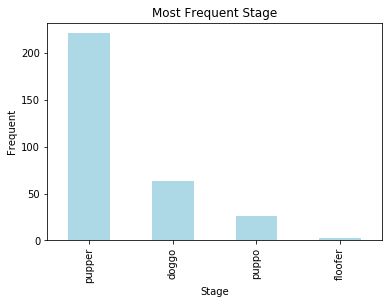

In [46]:
#plot shows the most frequent stage
df.dog_stage.value_counts().plot(kind = 'bar',color = 'lightblue')
plt.title('Most Frequent Stage')
plt.xlabel('Stage')
plt.ylabel('Frequent');

This plot shows that pupper has the most frequent stage.

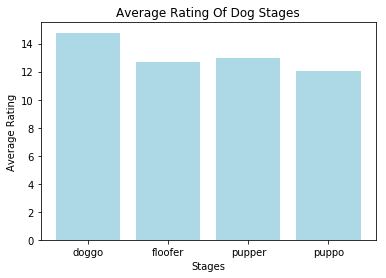

In [47]:
#plot shows the highest rating average
dog_stage_rating_avg = df.groupby('dog_stage').rating_numerator.mean()
plt.bar(dog_stage_rating_avg.index.values, dog_stage_rating_avg ,color = 'lightblue')
plt.title('Average Rating Of Dog Stages')
plt.xlabel('Stages')
plt.ylabel('Average Rating');

This plot shows that doggo has highest rating average.

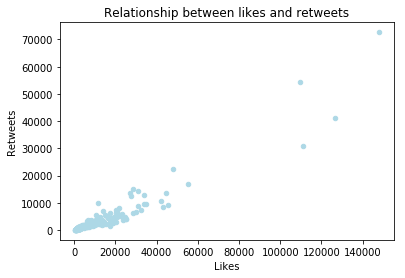

In [48]:
#scatter shows the relationship between likes and retweets

df.plot(kind='scatter',x='favorite_count',y='retweet_count', color = 'lightblue')
plt.title('Relationship between likes and retweets')
plt.xlabel('Likes')
plt.ylabel('Retweets');

This scatter shows there is a liner relationship between likes and retweets.